The purpose of this notebook is to do some initial proof-of-concept work investigating various burn severity metrics within Joshua Tree National Park and Mojave Valley National Preserve.

Importing required packages:

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import requests
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
import contextily as ctx
from src.query_sentinel import Sentinel2Client
from src.ingest_BARC import ingest_BARC_zip_file

In [40]:
SENTINEL2_PATH = "https://earth-search.aws.element84.com/v1"
response = requests.get(SENTINEL2_PATH)
print(response.json())

{'stac_version': '1.0.0', 'type': 'Catalog', 'id': 'earth-search-aws', 'title': 'Earth Search by Element 84', 'description': 'A STAC API of public datasets on AWS', 'links': [{'rel': 'self', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1'}, {'rel': 'root', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1'}, {'rel': 'conformance', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/conformance'}, {'rel': 'data', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/collections'}, {'rel': 'search', 'type': 'application/geo+json', 'href': 'https://earth-search.aws.element84.com/v1/search', 'method': 'GET'}, {'rel': 'search', 'type': 'application/geo+json', 'href': 'https://earth-search.aws.element84.com/v1/search', 'method': 'POST'}, {'rel': 'aggregate', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/aggregate', 'method': 'GET'}, {'rel': 'aggreg

The following is an excerpt from the [proposed scope of work](https://docs.google.com/document/d/1Mwad8O_T7LjNUSiKOD9egrlos9rd9EsNK09ABFrGQdA) between the NPS and DSE. Essentially, this notebook aims to validate the assumption baked into this proposal - that BAER / BARC maps (and the dNBR approach they employ) are insufficient estimates of burn severity in JOTR and MVNP. 

We will first investigate this by getting the BARC maps via the online portal, using the extent of those maps to query SentinelHub for sentinel2 data, and making some comparisons between the various classifications derived from each metric.

### Step 1 - Develop Data / Modelling Infrastructure

Inputs:
- High frequency, low spatial resolution, highest spectral resolution remote sensing data
	- `Sentinel-2`, ~~`LANDSAT`, `MODIS`~~
- ~~Low frequency, higher spatial resolution, low spectral resolution~~
	- ~~National Agricultural Imagery Program (`NAIP`)~~
- ~~One-off frequency, extremely high spatial resolution, variable spectral resolution~~
	- ~~LIDAR imagery from previous survey work~~

In the context of fire severity modelling, absolute metrics, such as the *Normalized Burn Ratio* ($NBR$), tend to be more effective for comparison across high and low biomass areas, but tend to be biased low in low biomass areas since the absolute changes ($dNBR$) are small in magnitude according to lack of adjustment. 

$$ NBR = \frac{NIR - SWIR}{NIR + SWIR} $$
$$ dNBR = NBR_{prefire} - NBR_{postfire}$$

To address these issues, some commonly accepted adjustments include the *Relative Difference in Normalized Burn Ratio* ($RdNBR$), as well as the *Relativized Burn Ratio* ($RBR$),  both of which attempt to adjust the relative change by the reflectance of the area pre-fire, such that fire severity is scaled to local reflectance in each given pixel.

$$RdNBR = \frac{dNBR}{|(NBR_{prefire})^{0.5}|}$$

$$ RBR = \frac{dNBR}{NBR_{prefire} +1.001}$$
Each of these metrics can be derived from satellite imagery, at various degrees of temporal and spatial resolution. The simplest approach would be to settle on one source (likely `Sentinel-2`, as it has the higher temporal resolution than `MODIS` and `LANDSAT`), and interpolate values between collection. However, a particular challenge identified in the case of immediate post-fire analysis is the potential occlusion of smoke - most approaches employ some manual approaches to find the best available pre-fire and post-fire images, which could lead to (1) some vegetative cover/biomass bias due phenology between image dates or (2) lag in analysis time in waiting for smoke-free imagery to be collected, since satellites return at best every 5 days. 

If we discover that relying on a imaging source is insufficient, either due to a lack of timeliness in imaging after fire (due to smoke or cloud occlusion) or simply due to issues with ground-truth accuracy (described in step 2), we may investigate a method which incorporates multiple imagery sources, as illustrated with `ESTARFM` fusion model employed in *Liu et. al. 2022*. 

First, we can grab the relevant data from the USGS' online portal (https://burnseverity.cr.usgs.gov/viewer/?product=BAER):

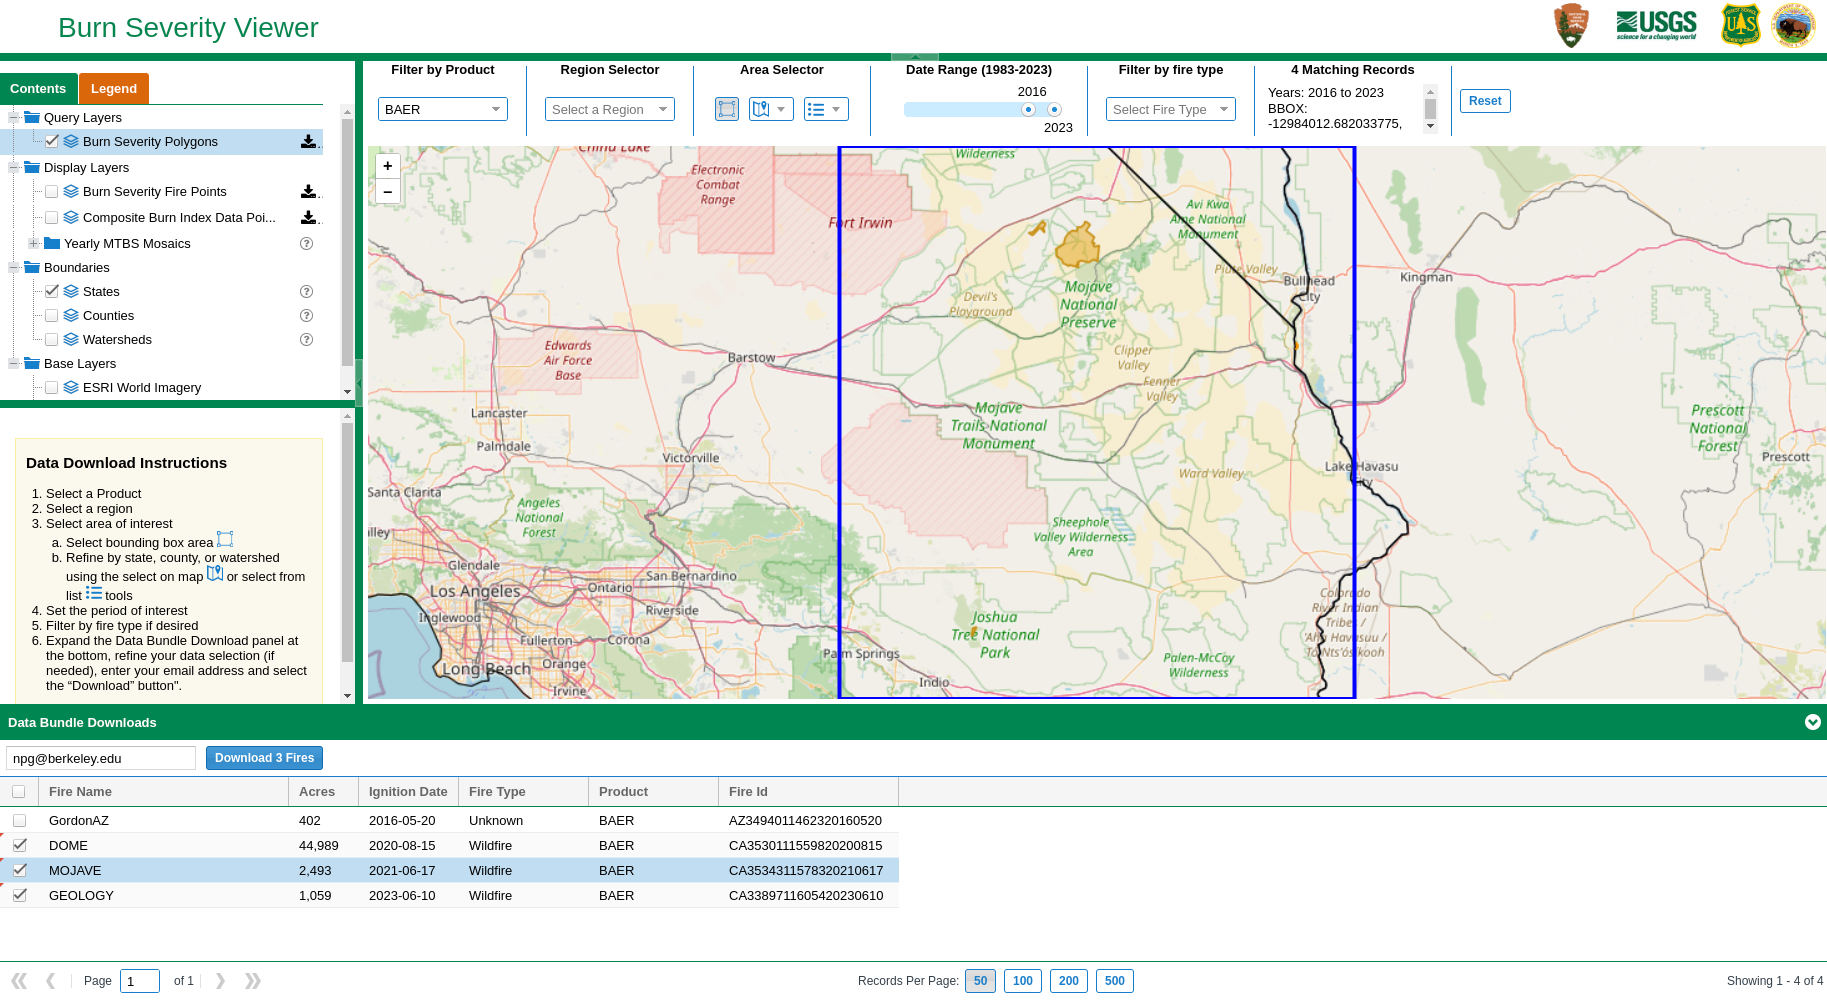

In [41]:
BARC_shps = ingest_BARC_zip_file("data/baer/2020/ca3530111559820200815.zip")

Found shapefile: ca3530111559820200815_20200808_20200902_burn_bndy.shp
Found shapefile: ca3530111559820200815_20200808_20200902_mask.shp


In [42]:
dome_boundary = BARC_shps[0]
dome_boundary

Event_ID                               irwinID Incid_Name  \
0  CA3530111559820200815  60146AC0-3AC8-462B-AC80-60D31F1B4D96       DOME   

  Incid_Type    Map_ID Map_Prog Asmnt_Type  BurnBndAc BurnBndLat BurnBndLon  \
0   Wildfire  10015640     BAER  Emergency      44989     35.304   -115.589   

   ... Perim_ID dNBR_offst dNBR_stdDv NoData_T  IncGreen_T  Low_T  Mod_T  \
0  ...     None        -12         11        0           0      0      0   

   High_T                          Comment  \
0       0  NIFS from 8/25 with minor edits   

                                            geometry  
0  POLYGON ((-1748536.243 1535050.001, -1748538.2...  

[1 rows x 23 columns]

In [43]:
dome_boundary

Event_ID                               irwinID Incid_Name  \
0  CA3530111559820200815  60146AC0-3AC8-462B-AC80-60D31F1B4D96       DOME   

  Incid_Type    Map_ID Map_Prog Asmnt_Type  BurnBndAc BurnBndLat BurnBndLon  \
0   Wildfire  10015640     BAER  Emergency      44989     35.304   -115.589   

   ... Perim_ID dNBR_offst dNBR_stdDv NoData_T  IncGreen_T  Low_T  Mod_T  \
0  ...     None        -12         11        0           0      0      0   

   High_T                          Comment  \
0       0  NIFS from 8/25 with minor edits   

                                            geometry  
0  POLYGON ((-1748536.243 1535050.001, -1748538.2...  

[1 rows x 23 columns]

<Axes: >

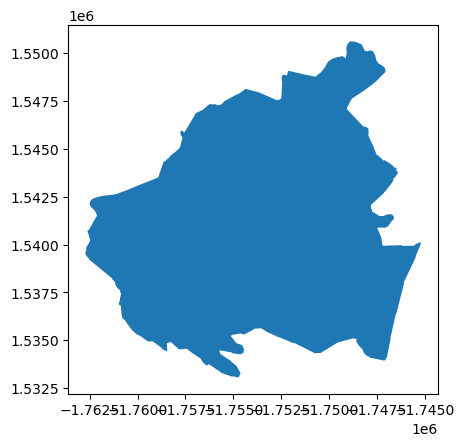

In [44]:
dome_boundary.plot()

In [45]:
dome_boundary = dome_boundary.to_crs("EPSG:4326")
dome_boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [93]:
s2_client_dome = Sentinel2Client(
    geojson_bounds=dome_boundary.geometry,
    buffer=0.1
)

Initialized Sentinel2Client with bounds: [-115.78999999999999, 35.12, -115.39, 35.49]


In [101]:
s2_client_dome.query_fire_event(
    prefire_date_range=("2020-07-15", "2020-08-15"),
    postfire_date_range=("2020-08-26", "2020-09-25"),
)

/opt/conda/envs/burn-severity/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/opt/conda/envs/burn-severity/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


After collapsing time dimension:


/opt/conda/envs/burn-severity/lib/python3.12/site-packages/dask/utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


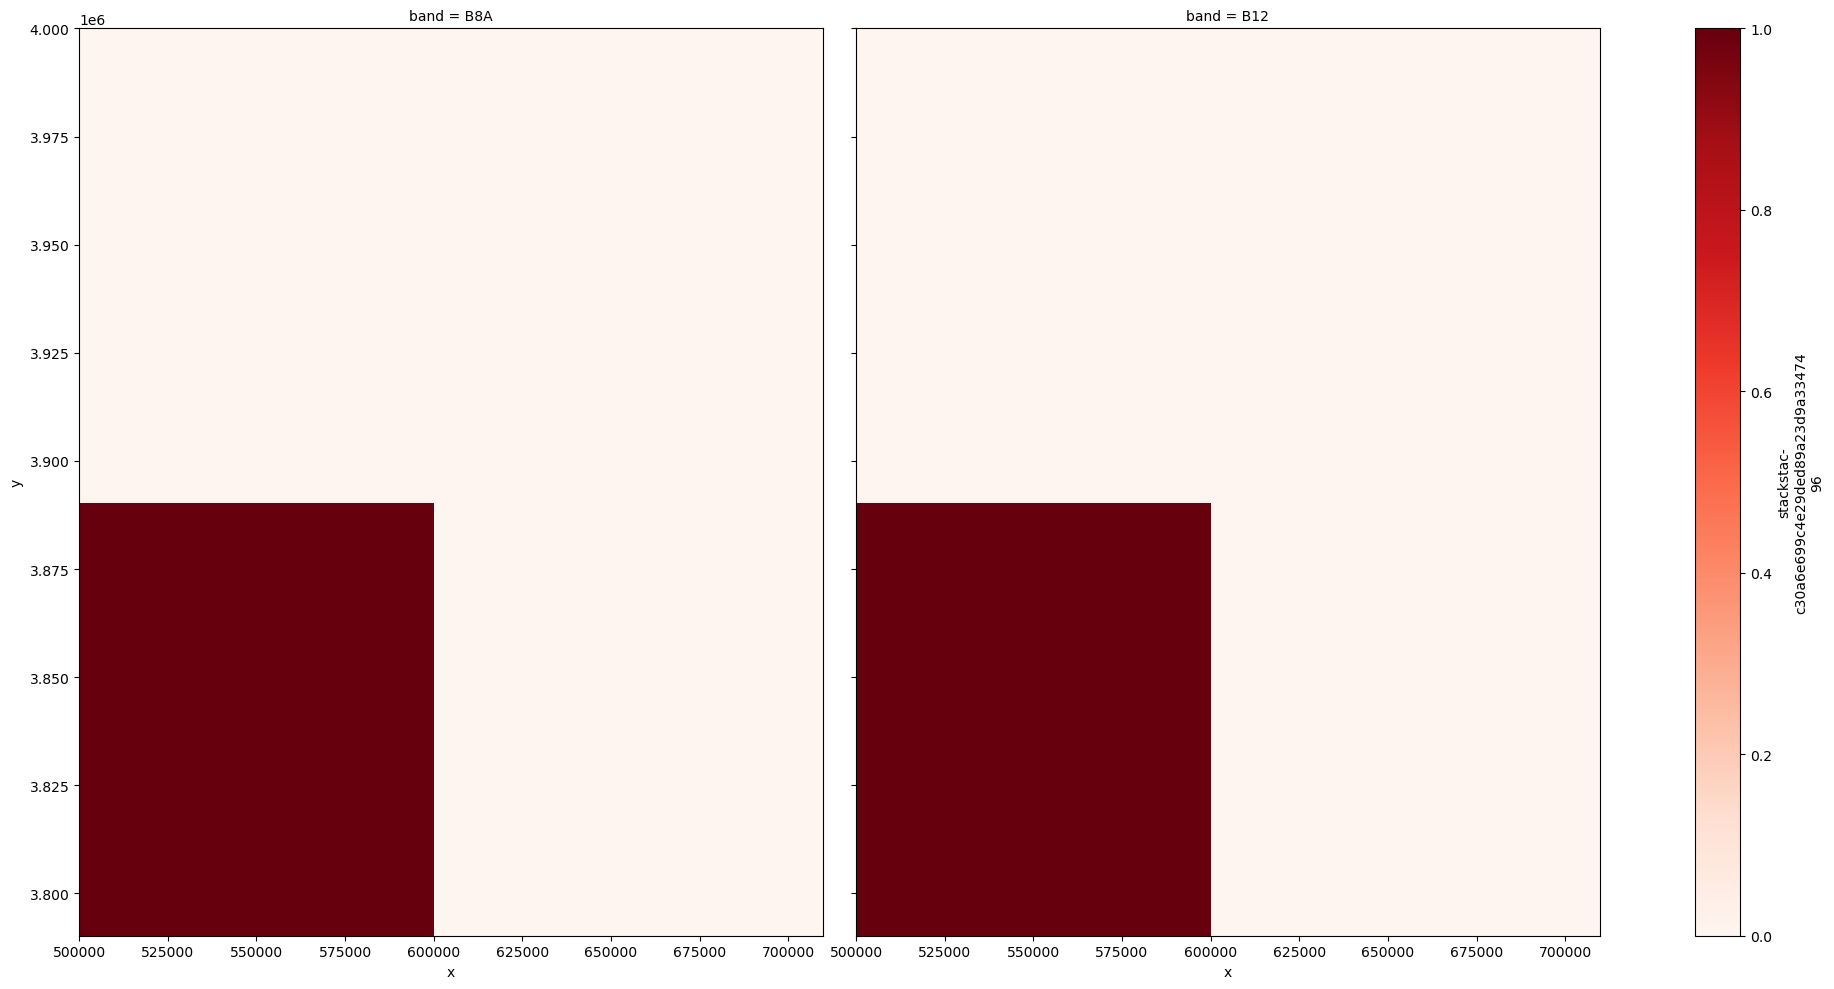

In [102]:
s2_client_dome.debug_missingness.plot(
    col="band",
    x="x",
    y="y",
    col_wrap=2,
    cmap="Reds",
    figsize=(20, 10),
);

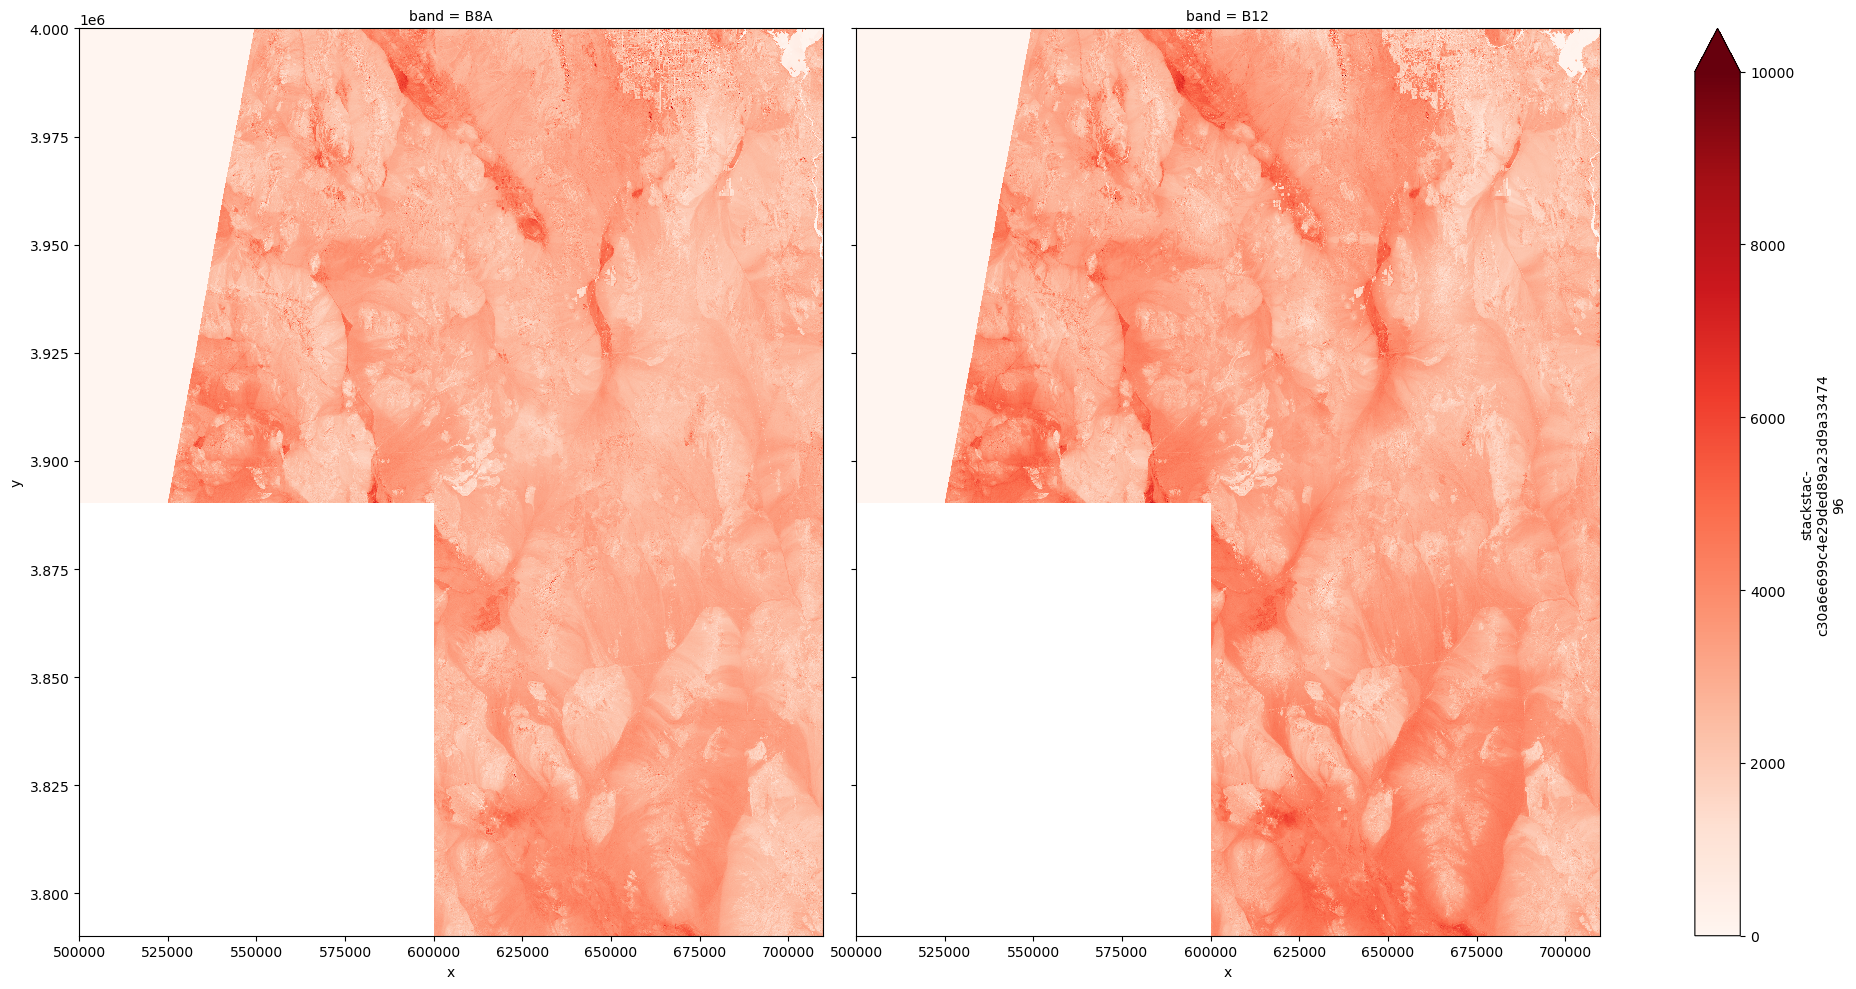

In [103]:
s2_client_dome.debug_reduced_stack.plot(
    col="band",
    x="x",
    y="y",
    col_wrap=2,
    cmap="Reds",
    figsize=(20, 10),
    vmin=0,
    vmax=10000
);

After clipping:

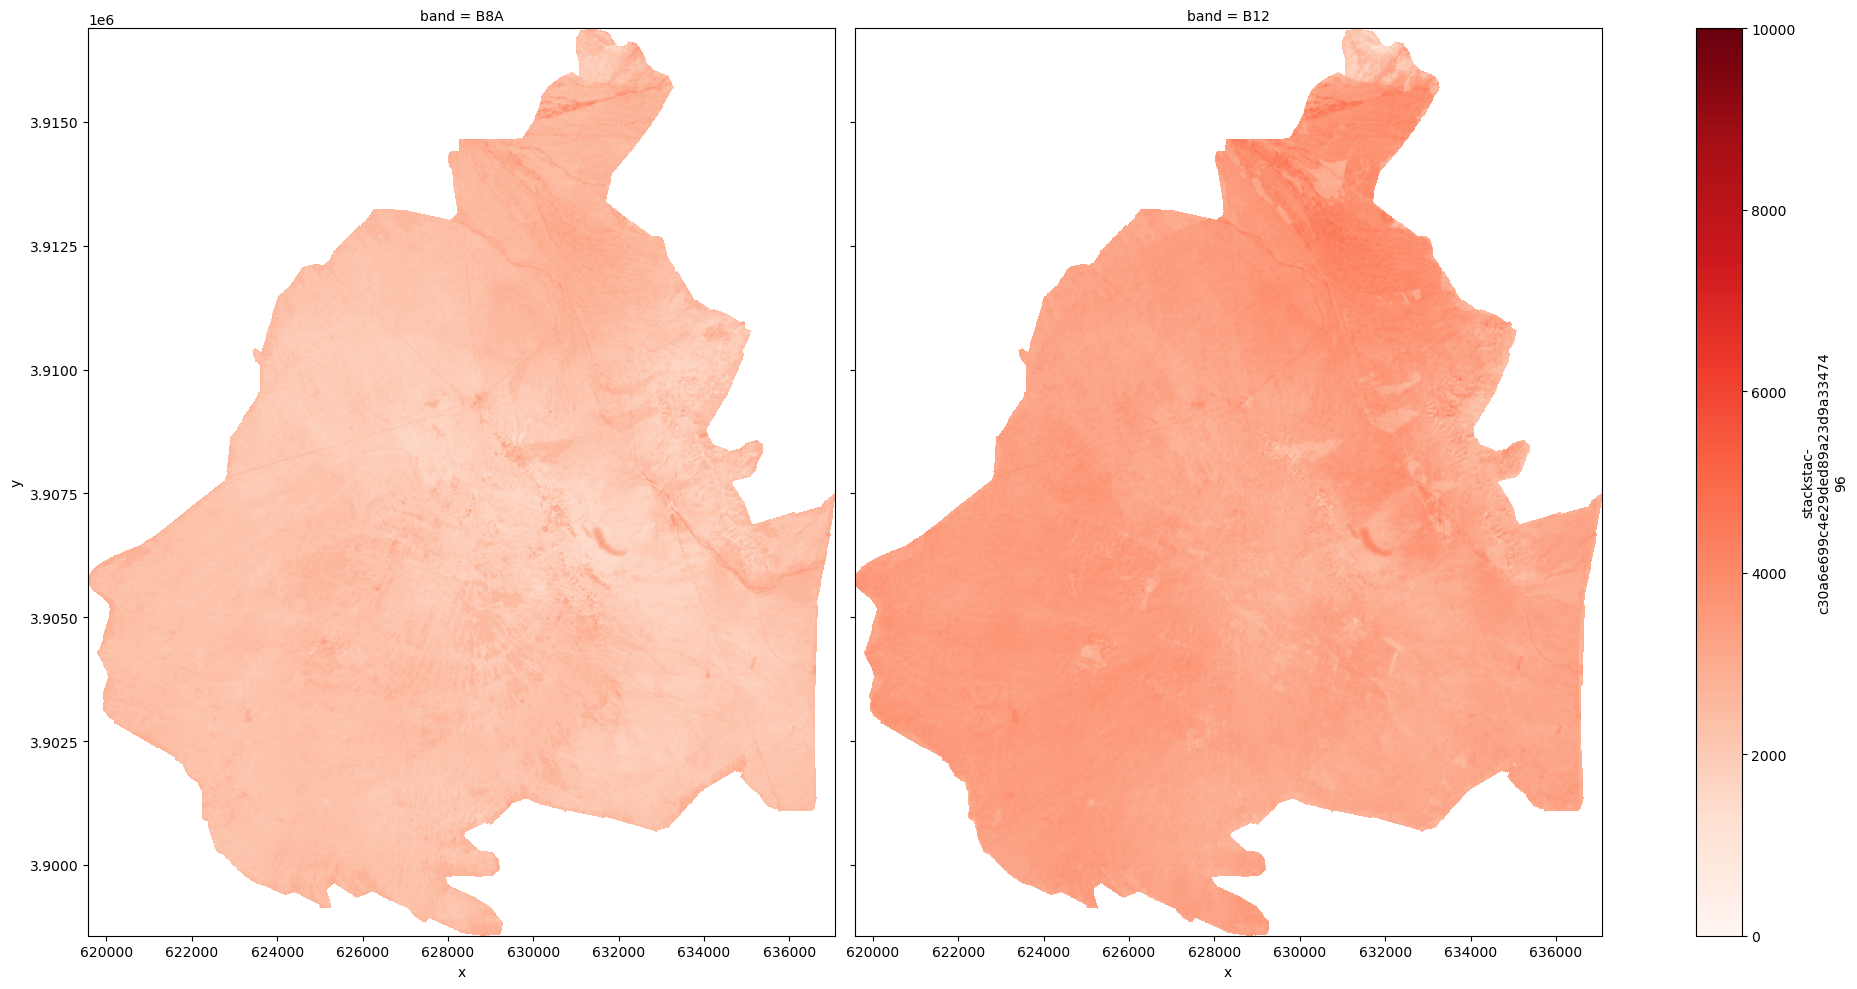

In [104]:
s2_client_dome.debug_clpped_stack.plot(
    col="band",
    x="x",
    y="y",
    col_wrap=2,
    cmap="Reds",
    figsize=(20, 10),
    vmin=0,
    vmax=10000
);

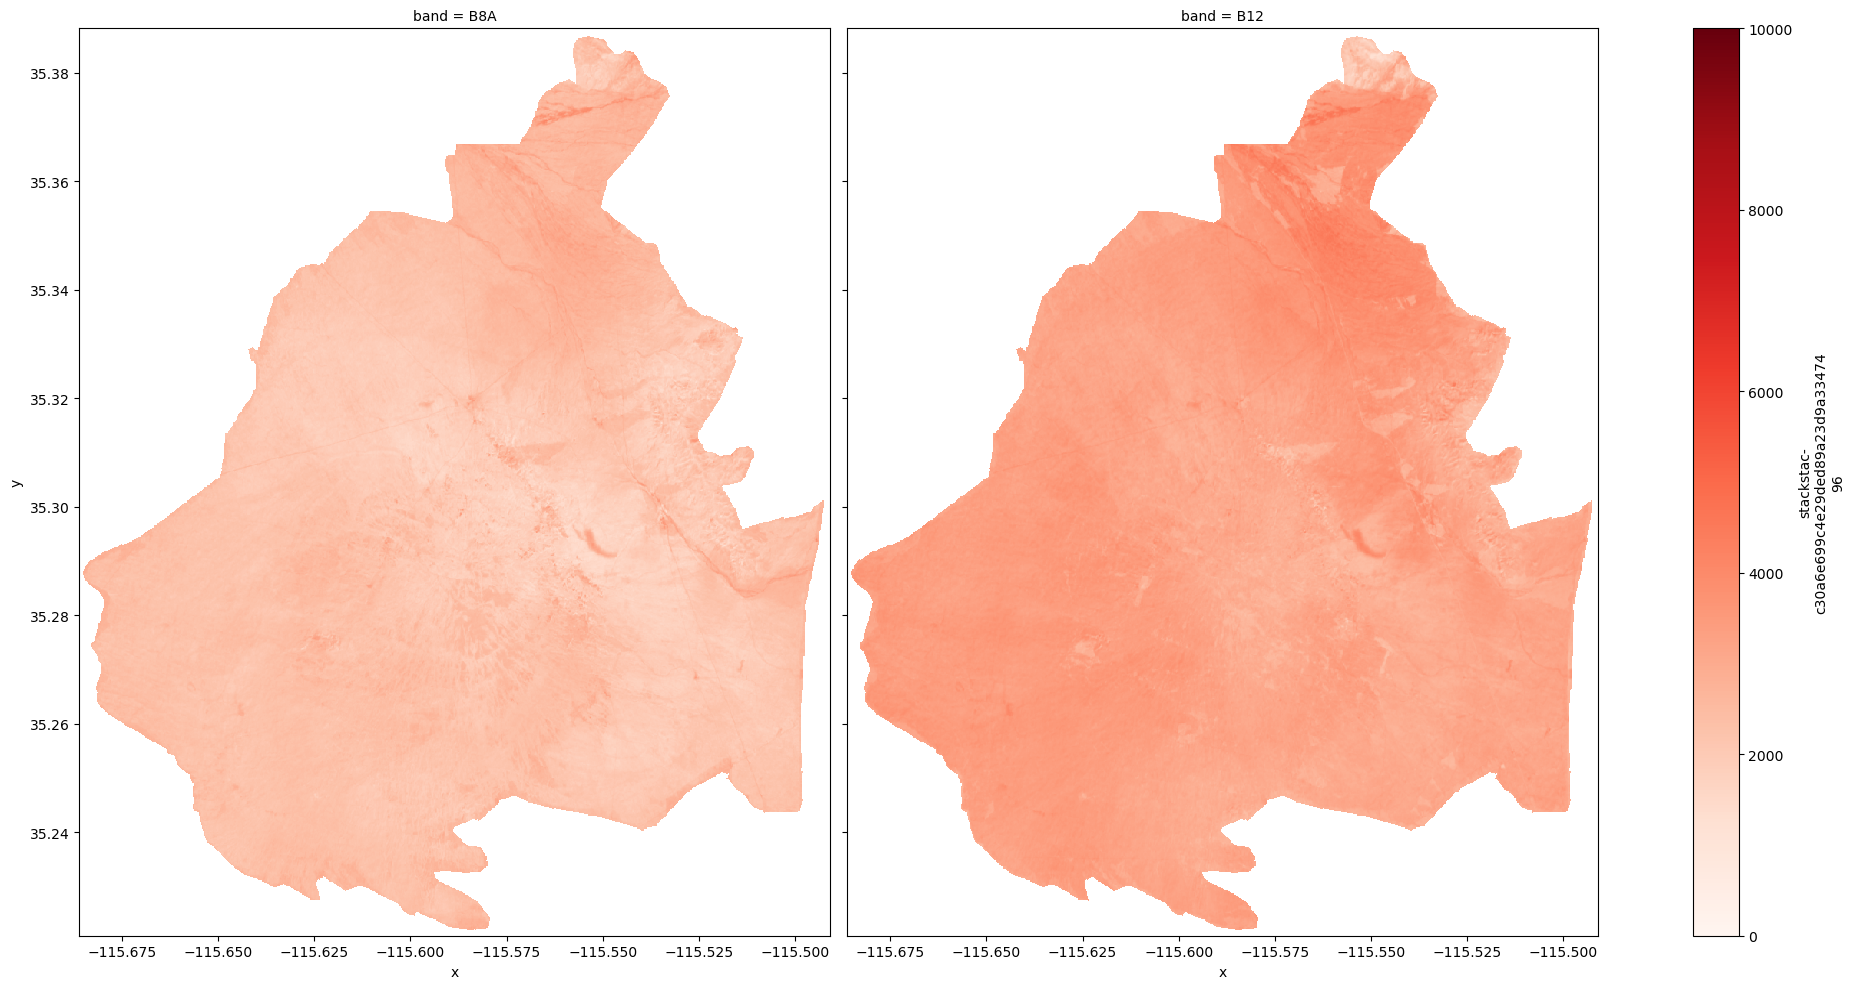

In [105]:
s2_client_dome.debug_reprojected_stack.plot(
    col="band",
    x="x",
    y="y",
    col_wrap=2,
    cmap="Reds",
    figsize=(20, 10),
    vmin=0,
    vmax=10000
);